In [1]:
import os
import h5py
import time
import torch
import pyreadr
import numpy as np
import pandas as pd
import datetime as dt
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from pandas.api.types import CategoricalDtype
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import weight_norm
from sklearn.manifold import TSNE
from livelossplot import PlotLosses
from pytorch_model_summary import summary
from tqdm.notebook import tqdm, trange

device = torch.device('cuda')

In [2]:
class MyDataset(torch.utils.data.Dataset):
    '''
    Class to load the dataset
    '''
    def __init__(self, w, y, idx):
        self.w = w
        self.y = y
        self.idx = idx
            
    def __len__(self):
        return len(self.idx)

    def __getitem__(self, idx):
            
        idx = self.idx[idx]
        
        ww = torch.tensor(self.w[idx], dtype=torch.float, device = device)
        yy = torch.tensor(self.y[idx], dtype=torch.float, device = device)
        
        return (ww, yy)

In [3]:
class MyNet(nn.Module):

    def __init__(self, w_layers, pred_layers):

        super().__init__()
              
        # CNN blocks
        w_layers_list = nn.ModuleList()
        for i, o, k, d in w_layers:
            w_layer = nn.Sequential(
                nn.Conv1d(i, o, k),
                nn.AvgPool1d(2),
                nn.LeakyReLU(),
                nn.BatchNorm1d(o),
                nn.Dropout(d)
            )
            w_layers_list.append(w_layer)
        w_layers_list.append(nn.AdaptiveAvgPool1d(1))
        self.w_layers = nn.Sequential(*w_layers_list)

        
        # FC blocks
        pred_layers_list = nn.ModuleList()
        for i, o, d in pred_layers:
            pred_layer = nn.Sequential(
                nn.Linear(i, o),
                nn.LeakyReLU(),
                nn.BatchNorm1d(o),
                nn.Dropout(d)
            )
            pred_layers_list.append(pred_layer)
        pred_layers_list.append(nn.Linear(o, 1))
        self.pred_layers = nn.Sequential(*pred_layers_list)
        
   
    def forward(self, Ws):
        
        feat = self.w_layers(Ws).view(Ws.shape[0], -1)
        pred = self.pred_layers(feat)
        return (torch.tanh(pred))


In [4]:
def load_data(wfiles, ydf, pct):
    sim_ww = []
    sim_yy = []

    wfile = wfiles[10]
    for wfile in tqdm(wfiles):   
        ridx = np.random.rand(10,10).argsort(1)[:,:pct]
        ridx = ridx + np.arange(0, 100, 10)[:,None]
        ridx = np.sort(ridx.reshape(-1))
        site = os.path.basename(wfile).replace('.csv', '')

        w = pd.read_csv(wfile, skiprows = 13)
        w.DAY = pd.to_datetime(w.DAY, format = '%Y%m%d').dt.date

        sydf = ydf.loc[site]
        sim_yy.append(sydf.Yield.values[ridx])

        wwf = []
        for crop_start_date in sydf.SIM_DATE.values[ridx]:
            cs_date = np.where(w.DAY == crop_start_date)[0][0]
            wrng = slice(cs_date-90, cs_date+210)
            ww = w.iloc[wrng,[1,2,3,4,6]].values / ws
            wwf.append(ww)

        sim_ww.append(np.concatenate(wwf))

    sim_ww = np.stack(sim_ww)
    sim_yy = np.stack(sim_yy)
    return(sim_ww, sim_yy)


In [23]:
PCT = 1
REP = 3

In [24]:
# Values used to scale the weather data:
ws = np.array([[[5e4,50,50,5,100.0]]])

In [25]:
ydf = pd.read_hdf('../data/PSCE_TILE.h5', key = 'SIM').set_index('SIM')
ydf['Yield'] = (ydf.TWSO/2e4)

In [26]:
wdir = '/home/rodrigo7/Apsim_test/MASAGRO/DAYMET_TILE'
pxy = np.stack(np.meshgrid(np.arange(40), np.arange(40)), -1).reshape(-1, 2)
wfiles = [f'{wdir}/DAYMET_9584_{px:02d}_{py:02d}.csv' for px, py in pxy]

sim_ww, sim_yy = load_data(wfiles, ydf, PCT)

In [27]:
wd = np.zeros_like(sim_ww[:,:,:,[0]])
wd = wd + np.linspace(-0.9,2.1,300)[None,None,:,None]
W = np.concatenate([sim_ww, wd], -1)
W = np.moveaxis(W, -1, -2)

In [28]:
w_std = W.std((0,1,3))
w_std[-1] = 0
w_std = torch.tensor(w_std, device = device, dtype = torch.float)[:,None]

In [29]:
# Select the first 8 years to use for training/validation:
train_val_W = W[:,:int(8*PCT)].reshape(-1, *W.shape[2:])
train_val_y = sim_yy[:,:int(8*PCT)].reshape(-1, *sim_yy.shape[2:])

test_val_W = W[:,int(8*PCT):].reshape(-1, *W.shape[2:])
test_val_y = sim_yy[:,int(8*PCT):].reshape(-1, *sim_yy.shape[2:])

In [30]:
# Select the first 8 years to use for training/validation:
pred_idx = np.arange(len(test_val_y))

train_idx = np.arange(len(train_val_y))
val_idx = np.random.choice(train_idx, size=int(0.2*len(train_idx)), replace=False)
train_idx = np.setdiff1d(train_idx, val_idx)
print(train_idx.shape, val_idx.shape)

(10240,) (2560,)


In [31]:
batch_size = 100

test_dataset = MyDataset(test_val_W, test_val_y, pred_idx)
train_dataset = MyDataset(train_val_W, train_val_y, train_idx)
val_dataset = MyDataset(train_val_W, train_val_y, val_idx)


test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

data_inputs = iter(train_loader).next()
print(len(train_loader))


103


In [39]:
d = 0.1
w_layers =  [[6,12,3,d],[12,15,5,d],[15,20,7,d],[20,25,5,d],[25,100,3,d]]
pred_layers = [[100,50,d],[50,50,d], [50,25,d]]

model = MyNet(w_layers, pred_layers)
model = model.to(device)

sm = summary(model, data_inputs[0], print_summary=True,  max_depth=1)

----------------------------------------------------------------------------
           Layer (type)        Output Shape         Param #     Tr. Param #
               Conv1d-1      [100, 12, 298]             228             228
            AvgPool1d-2      [100, 12, 149]               0               0
            LeakyReLU-3      [100, 12, 149]               0               0
          BatchNorm1d-4      [100, 12, 149]              24              24
              Dropout-5      [100, 12, 149]               0               0
               Conv1d-6      [100, 15, 145]             915             915
            AvgPool1d-7       [100, 15, 72]               0               0
            LeakyReLU-8       [100, 15, 72]               0               0
          BatchNorm1d-9       [100, 15, 72]              30              30
             Dropout-10       [100, 15, 72]               0               0
              Conv1d-11       [100, 20, 66]           2,120           2,120
           

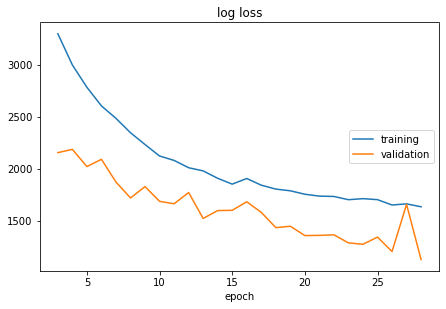

log loss:
training   (min: 1633.428, max: 7932.710, cur: 1633.428)
validation (min: 1126.128, max: 2989.513, cur: 1126.128)
[0:27] loss: 0.007 time:4.76 train_method: adv


In [ ]:
epsilon = 0.1
alpha = 0.1
train_methods = ['none', 'rnd', 'adv']

for train_method in train_methods:
    model = MyNet(w_layers, pred_layers)
    model = model.to(device)
    model_file_name = f'../data/model_cnn_{train_method}_{PCT}_{REP}.pth'
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    min_loss = 10
    bad_epochs = 0
    liveloss = PlotLosses()

    for epoch in range(1000):
        start_time = time.time()
        epoch_loss = []
        val_loss = []

        model.train()
        for i, (Ws, Ys) in enumerate(tqdm(train_loader)):

            if train_method == 'rnd':
                # Generates normaly distributed random data with SD = epsilon 
                delta = epsilon * torch.randn_like(Ws)

                # Multiply delta by the SD of each variable to keep the proportion
                # and crop to the valid range:
                rnd_data = torch.clamp(Ws + w_std * delta, 0, 1)

                # Replace the data with the noisy version:
                Ws = rnd_data

            elif train_method == 'adv':
                # Generates normaly distributed random data with SD = epsilon 
                delta = epsilon * torch.randn_like(Ws)

                # Set the parameter to enable gradiante calculation
                delta.requires_grad = True

                # Run the model in the noisy data
                output = model(Ws + w_std * delta)

                # Calc the loss
                loss = criterion(output, Ys[:,None])

                # Calc the gradiantes
                loss.backward()

                # Aply the FGSM to move the random values to an adv direction
                delta = delta.data.detach() + alpha * torch.sign(delta.grad.detach())

                # Clip the perturbations to reasonable limits (3*SD)
                delta = torch.clamp(delta, -3*epsilon, 3*epsilon)

                # Multiply delta by the SD of each variable to keep the proportion
                # and crop to the valid range:
                adv_data = torch.clamp(Ws + w_std * delta, 0, 1)

                # Replace the data with the adversarial version
                Ws = adv_data

            # Proceed with normal training steps

            # Get the prediction
            output = model(Ws)

            # Calc the loss
            loss = criterion(output, Ys[:,None])

            # Clear the gradients
            optimizer.zero_grad()

            # Calc new gradients
            loss.backward()

            # Update model parameters
            optimizer.step()

            # Store mini-batch loss
            epoch_loss.append(loss.data.item())

        # Set the model to eval
        model.eval()

        # Evaluate the model in the validation set
        for i, (Ws, Ys) in enumerate(tqdm(val_loader)):

            # Get the prediction
            with torch.no_grad():
                outputs = model(Ws)

            # Calc the loss
            loss = criterion(outputs, Ys[:,None])

            # Store mini-batch loss
            val_loss.append(loss.data.item())

        # Get average train and val losses
        epoch_loss = np.array(epoch_loss).mean()
        val_loss = np.array(val_loss).mean()

        # Apply the early stopping criteria
        if val_loss < min_loss:
            torch.save(model.state_dict(), model_file_name)
            bad_epochs = 0
            min_loss = val_loss
        else:
            bad_epochs += 1

        if bad_epochs > 50:
            break

        # Update the loss with the RMSE in the original yield scale (Mg/ha)
        liveloss.update({
            'log loss': np.sqrt(epoch_loss) * 2e4,
            'val_log loss': np.sqrt(val_loss) * 2e4
        })
        liveloss.draw()

        # Get total time per epoch
        time_taken = time.time() - start_time

        # Print some diagnostics
        print(f'[{bad_epochs}:{epoch}] loss: {epoch_loss:.3f} time:{time_taken:.2f} train_method: {train_method}')
